In [2]:
import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [3]:
fifa20=pd.read_csv("https://raw.githubusercontent.com/LucasAfa/Projeto1-IF775/master/dbs/players_20.csv")

In [4]:
fifa20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [5]:
#Removendo Colunas que não serão usadas na análise

fifa20=fifa20.drop(columns=['work_rate','real_face','body_type','long_name','international_reputation','ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb'], axis=1)
fifa20.head()

,sofifa_id,player_url,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,weak_foot,skill_moves,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,4,4,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,4,5,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,1,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,"Flair, Acrobatic Clearance",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Selfish, Finesse Shot, Spee...",81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8


In [6]:
# Setando colunas que fazem sentido serem categóricas
fifa20['player_url'] = fifa20['player_url'].astype('category')
fifa20['short_name'] = fifa20['short_name'].astype('category')
fifa20['dob'] = fifa20['dob'].astype('datetime64[ns]')
fifa20['nationality'] = fifa20['nationality'].astype('category')
fifa20['club'] = fifa20['club'].astype('category')
fifa20['preferred_foot'] = fifa20['preferred_foot'].astype('category')
fifa20['team_position'] = fifa20['team_position'].astype('category')
fifa20['nation_position'] = fifa20['nation_position'].astype('category')
fifa20['country_code'] = fifa20['nationality'].cat.codes
fifa20['club_code'] = fifa20['club'].cat.codes

fifa20.dtypes

sofifa_id                           int64
player_url                       category
short_name                       category
age                                 int64
dob                        datetime64[ns]
                                ...      
goalkeeping_kicking                 int64
goalkeeping_positioning             int64
goalkeeping_reflexes                int64
country_code                        int16
club_code                           int16
Length: 75, dtype: object

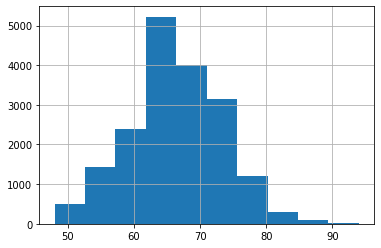

In [7]:
# avaliando se temos uma curva normal nas habilidades atuais dos jogadores
fifa20.overall.hist()

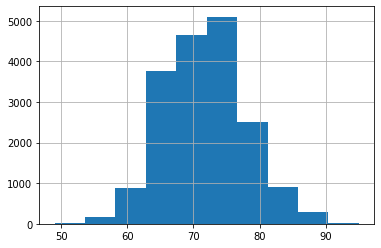

In [8]:
# avaliando se temos uma curva normal nas habilidades futuras dos jogadores
fifa20.potential.hist()

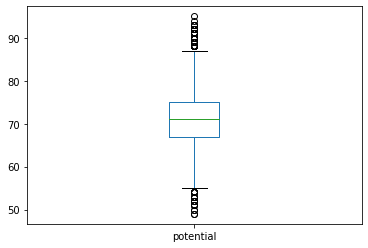

In [9]:
# avaliando como está a distribuição de outlyers dos potenciais
fifa20['potential'].plot.box()


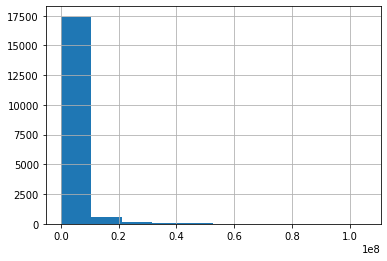

In [10]:
# avaliando se temos uma curva normal nas habilidades futuras dos jogadores
fifa20.value_eur.hist()

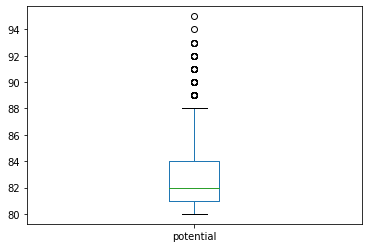

In [11]:
# Afim de reduzir a quantidade de dados úteis para nossa analise, iremos dropar os jogadores com potencial abaixo do terceiro quartil, pois após plotar o histograma e o plotbox, além do conhecimento geral sobre o jogo,
# Sabemos que existem milhares de jogadores mas são poucos os que se destacam, e nesse caso, queríamos analisar os destaques. Porém, não bastava apenas literalmente os outlyers, pois eles seriam por assim dizer os "incriveis",
# Mas também queremos os jogadores "bons" e "ótimos" Ajustamos o valor a constante multiplicativa do IQR para 0.5, assim conseguimos jogadores com potencial minimo de 80, o que dentro do fifa, são considerados jogadores Ouro

q1 = fifa20['potential'].quantile(q=0.25)
q3 = fifa20['potential'].quantile(q=0.75)
iqr = q3 - q1

fifa20= fifa20[fifa20['potential'] > (q3 + 0.5 * iqr)]
fifa20['potential'].plot.box()

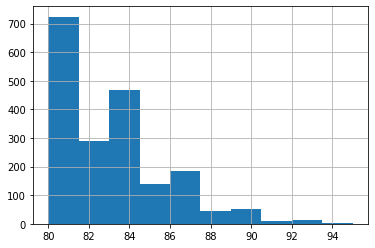

In [12]:
# avaliando se temos uma curva normal nas habilidades futuras dos jogadores após a limpa dos jogadores
fifa20.potential.hist()

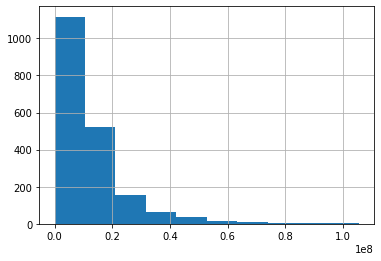

In [13]:
# avaliando se temos uma curva normal nos valores dos jogadores
fifa20.value_eur.hist()

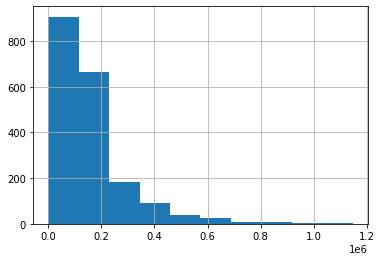

In [14]:
# Após a limpa, queremos analisar o impacto da força atual do jogador em seu preço

fifa20['price_per_overall'] = fifa20['value_eur']/fifa20['overall']
fifa20.price_per_overall.hist()

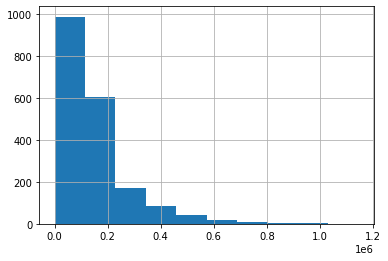

In [15]:
# Após a limpa, queremos analisar o impacto da força futura do jogador em seu preço

fifa20['price_per_potential'] = fifa20['value_eur']/fifa20['potential']
fifa20.price_per_potential.hist()

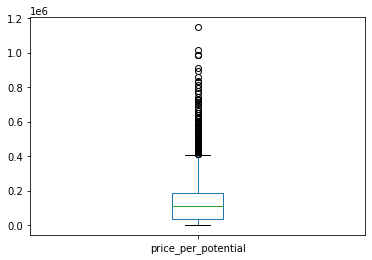

In [16]:
# Queremos avaliar se faz sentido remover os outlyers no que se refere à preço por potencial. Entretanto, não faz sentido após pensar e testar algumas formas de normalização, então vamos analisar correlações

fifa20['price_per_potential'].plot.box()

In [17]:
# Buscamos analisar as correlações e encontrar as que fazem mais sentido impactar nos jogadores, sempre focando no preço e desempenho (força atual e potencial)
# Com isso escolhemos as relações de idade e preço por potencial, como as mais interessantes que julgamos para o momento

fifa20[fifa20.potential > 80].corr(method='spearman')


,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,country_code,club_code,price_per_overall,price_per_potential
sofifa_id,1.000000,-0.880977,-0.118447,-0.221516,-0.812806,-0.091940,-0.737686,-0.717304,-0.103167,-0.102506,-0.710234,0.306538,0.062424,0.185845,0.004662,-0.404055,-0.556466,-0.442311,-0.317813,-0.424250,-0.706871,-0.742501,-0.531261,-0.665482,-0.553248,-0.793771,-0.290012,-0.193444,-0.231418,-0.468791,-0.271504,-0.275530,-0.285645,-0.262365,-0.368992,-0.423465,0.076755,0.052851,-0.041672,-0.724193,-0.015097,-0.406264,-0.263817,-0.271851,-0.299231,-0.300093,-0.268486,-0.245067,-0.285537,-0.395983,-0.243802,-0.560667,-0.207477,-0.180952,-0.145159,-0.130552,-0.128613,-0.103158,-0.095690,-0.084326,0.062200,-0.013964,-0.728048,-0.745940
age,-0.880977,1.000000,0.140533,0.265981,0.855558,0.014734,0.733290,0.676906,0.085363,0.070715,0.722621,-0.333785,-0.042519,-0.245130,-0.041437,0.392316,0.547640,0.408723,0.378518,0.486722,0.698330,0.777435,0.547790,0.659333,0.511974,0.833293,0.267126,0.173349,0.280218,0.474085,0.261291,0.243405,0.260117,0.247314,0.380442,0.401026,-0.108743,-0.087281,-0.012535,0.781898,-0.038678,0.405605,0.282869,0.296730,0.347990,0.291099,0.325064,0.293652,0.275177,0.373093,0.234135,0.582534,0.251857,0.223498,0.191220,0.142171,0.138596,0.124889,0.122927,0.106021,-0.027123,0.047524,0.722202,0.743194
height_cm,-0.118447,0.140533,1.000000,0.791135,0.113121,0.008803,0.059959,0.069908,-0.165887,-0.507319,0.058302,-0.055414,0.012256,-0.256501,-0.442620,-0.244903,-0.280518,-0.451609,0.339678,0.550050,0.046573,0.064496,0.062521,0.016062,-0.077073,0.114947,-0.478875,-0.380599,0.333952,-0.249827,-0.353975,-0.492215,-0.457808,-0.409014,-0.217379,-0.378515,-0.614898,-0.428419,-0.732260,0.059903,-0.854980,-0.190499,0.214878,-0.208970,0.624472,-0.366817,0.129171,0.103895,-0.388510,-0.355934,-0.322795,-0.118310,0.102531,0.105506,0.078227,0.146792,0.163632,0.144093,0.188213,0.171809,0.026080,-0.019684,0.054221,0.059645
weight_kg,-0.221516,0.265981,0.791135,1.000000,0.233820,0.014309,0.170267,0.166531,-0.111886,-0.448600,0.171828,-0.128032,0.001416,-0.229803,-0.349552,-0.133558,-0.178095,-0.334805,0.336751,0.618881,0.267289,0.310713,0.303905,0.209165,0.146048,0.357534,-0.372991,-0.294470,0.351631,-0.158559,-0.258776,-0.391454,-0.357299,-0.316751,-0.153255,-0.277162,-0.519010,-0.347836,-0.647798,0.167059,-0.713855,-0.047587,0.275627,-0.139768,0.688423,-0.264627,0.189134,0.115983,-0.283042,-0.273163,-0.241079,-0.032361,0.119004,0.116965,0.088575,0.140973,0.176672,0.134568,0.171889,0.154619,-0.010320,-0.009401,0.164241,0.171160
overall,-0.812806,0.855558,0.113121,0.233820,1.000000,0.406456,0.946241,0.817049,0.153984,0.187865,0.945402,-0.334537,0.109497,-0.120748,0.098842,0.500428,0.672850,0.575151,0.352302,0.483769,0.924172,0.909022,0.671835,0.895576,0.554710,0.941484,0.371735,0.278925,0.279573,0.601238,0.355880,0.398012,0.377016,0.322115,0.463701,0.558763,0.019218,0.053525,0.108999,0.918861,0.056313,0.514902,0.276261,0.381272,0.331298,0.392400,0.325268,0.295814,0.390056,0.509698,0.292735,0.732393,0.249296,0.220377,0.178914,0.104999,0.

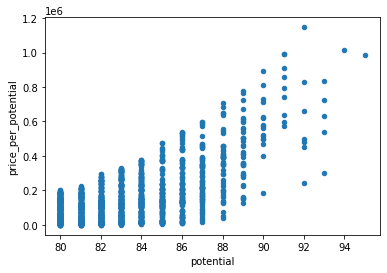

In [18]:
# Aqui buscamos visualizar a relação direta entre potencial e o preço por potencial, porém sentimos falta de conseguir analisar o impacto da força atual nisso tudo

fifa20.plot.scatter(x="potential", y="price_per_potential")

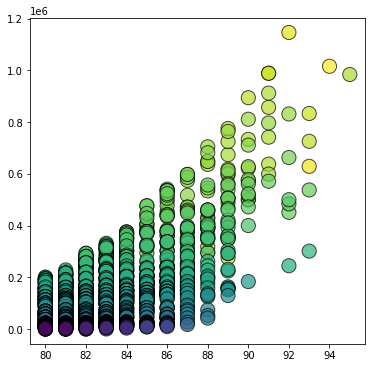

In [19]:
# Aqui conseguimos fazer uma correlação tripla, usando a cor para simular um terceiro eixo que seria a força atual, e conseguimos perceber a variação do preço baseado nesses eixos, 
# Já que nas cores que se aproximam do roxo o jogador é mais fraco e nas cores mais claras ele está mais forte.


x = fifa20['potential']
y = fifa20['price_per_potential']
z = fifa20['overall']

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

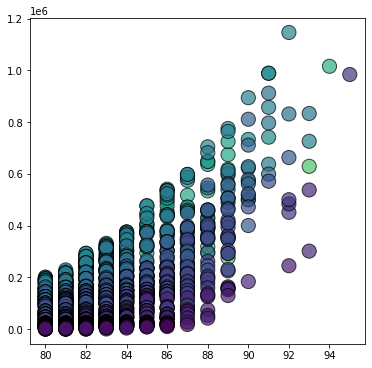

In [20]:
# Aqui conseguimos fazer uma correlação tripla, usando a cor para simular um terceiro eixo que seria a idade, e conseguimos perceber que a idade impacta diretamente no preço por potencial, 
# E podemos deduzir que é pelo quanto um jogador pode evoluir de novo até seu auge 
# Já que nas cores que se aproximam do roxo o jogador é mais novo e nas cores mais claras ele está mais velho.
# Plotar o principal outlyer

x = fifa20['potential']
y = fifa20['price_per_potential']
z = fifa20['age']

fig = plt.figure(figsize=(6, 6))
plt.scatter(x, y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [21]:
# Ao observar o gráfico acima, percebemos um jogador que se destaca totalmente totalmente dos outros, sendo bem novo e tendo um potencial acima de 94, vamos pegar ele como referência aqui
# Para mostrar que faz sentido essa analise, e que realmente a idade e a sua força atual também influencia no seu preço por potencial.

fifa20[(fifa20['potential'] > 94)]

,sofifa_id,player_url,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,weak_foot,skill_moves,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,country_code,club_code,price_per_overall,price_per_potential
10,231747,https://sofifa.com/player/231747/kylian-mbappe...,K. Mbappé,20,1998-12-20,178,73,France,Paris Saint-Germain,89,95,93500000,155000,"ST, RW",Right,4,5,191700000.0,"#Speedster, #Dribbler, #Acrobat",RW,7.0,NaN,2018-07-01,2022.0,RM,10.0,96.0,84.0,78.0,90.0,39.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Selfish, Early Crosser, Spe...",78,89,77,82,79,91,79,63,70,90,96,96,92,89,83,83,76,84,76,79,62,38,89,80,70,84,34,34,32,13,5,7,11,6,53,462,1.050562e+06,984210.526316


In [22]:
# Para exemplificar um pouco mais, no gráfico percebemos outros 3 jogadores novos mas com bastante potencial, porém seus valores são bem mais baixos que o do Mbappé mostrado acima
# Ao pegar eles aqui, percebemos que é justamente porque a força atual deles é bem abaixo da de Mbappé, por exemplo

fifa20[(fifa20['potential'] > 89) & (fifa20['price_per_potential'] < 400000)]

,sofifa_id,player_url,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,weak_foot,skill_moves,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,country_code,club_code,price_per_overall,price_per_potential
411,242444,https://sofifa.com/player/242444/joao-felix-se...,João Félix,19,1999-11-10,181,70,Portugal,Atlético Madrid,80,93,28000000,38000,"CF, ST",Right,4,5,74900000.0,NaN,RS,7.0,NaN,2019-07-03,2026.0,RS,23.0,82.0,80.0,74.0,81.0,40.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,"Selfish, Finesse Shot, Speed Dribbler (CPU AI ...",73,79,69,76,79,82,81,58,67,80,79,85,83,83,80,82,79,79,64,80,69,38,84,77,68,82,30,42,35,13,12,14,13,14,121,63,350000.000000,301075.268817
568,238794,https://sofifa.com/player/238794/vinicius-jose...,Vinícius Jr.,18,2000-07-12,176,73,Brazil,Real Madrid,79,92,22500000,60000,LW,Right,4,5,60200000.0,"#Speedster, #Dribbler, #Acrobat",RW,28.0,NaN,2018-07-12,2025.0,NaN,NaN,93.0,70.0,71.0,85.0,29.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,"Selfish, Early Crosser, Speed Dribbler (CPU AI...",71,68,50,73,70,86,77,62,67,82,92,94,93,77,83,74,75,79,60,68,48,26,76,73,65,77,32,25,18,5,7,7,7,10,18,505,284810.126582,244565.217391
1254,237692,https://sofifa.com/player/237692/phil-foden/20...,P. Foden,19,2000-05-28,171,69,England,Manchester City,76,90,16500000,52000,"CAM, CM",Left,3,4,40800000.0,NaN,SUB,47.0,NaN,2016-07-01,2024.0,NaN,NaN,74.0,64.0,74.0,79.0,55.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Crowd Favourite",68,66,47,80,48,77,68,57,74,79,77,72,87,69,89,70,49,72,44,61,62,58,69,76,48,78,56,58,47,8,15,6,10,13,45,400,217105.263158,183333.333333


In [23]:
# Hipoteses para serem testadas: o país influencia no seu potencial?

stats.stats.kruskal(*[group["potential"].values for name, group in fifa20.groupby("country_code")])


KruskalResult(statistic=100.59082786190265, pvalue=0.23074416773822187)

In [53]:
# Hipoteses para serem testadas: o país influencia no seu preço por potencial?

stats.stats.kruskal(*[group["price_per_potential"].values for name, group in fifa20.groupby("country_code")])


KruskalResult(statistic=184.28783378869184, pvalue=2.6902318397628494e-08)

In [25]:
# Hipoteses para serem testadas: o país influencia no seu preço por força atual?

stats.stats.kruskal(*[group["price_per_overall"].values for name, group in fifa20.groupby("country_code")])


KruskalResult(statistic=180.65671039770325, pvalue=6.939360521996227e-08)

In [66]:
# Hipoteses para serem testadas: o país influencia na força atual? 

stats.stats.kruskal(*[group["overall"].values for name, group in fifa20.groupby("country_code")])


KruskalResult(statistic=201.78915400986227, pvalue=2.2443840402380984e-10)

In [58]:
# pegar grupos separados de países para avaliar essas hipoteses, pegar o máximo e o minimo do potencial
fifa20.groupby("country_code").mean()

,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,club_code,price_per_overall,price_per_potential
country_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,217938.333333,23.666667,185.666667,74.666667,77.333333,84.000000,1.403333e+07,34666.666667,3.000000,2.333333,2.493333e+07,15.333333,2022.666667,NaN,74.500000,59.500000,60.500000,71.500000,53.500000,71.500000,84.000000,78.000000,75.000000,87.0,44.000000,79.000000,45.333333,45.000000,48.000000,56.333333,37.666667,51.000000,32.000000,33.000000,46.000000,54.666667,63.666667,64.666667,60.000000,73.666667,64.000000,64.333333,64.000000,58.333333,69.333333,39.666667,52.333333,38.666667,51.000000,52.333333,44.333333,68.000000,47.666667,37.666667,37.666667,34.333333,31.333333,32.333333,32.000000,37.333333,281.666667,175026.132404,164508.706846
2,215134.833333,24.666667,179.166667,72.500000,76.916667,82.000000,1.213333e+07,47916.666667,3.500000,3.583333,2.345000e+07,31.500000,2022.333333,NaN,76.250000,65.916667,72.416667,77.666667,58.583333,66.500000,NaN,NaN,NaN,NaN,NaN,NaN,74.083333,63.500000,61.666667,74.833333,63.000000,78.583333,71.000000,60.833333,69.250000,78.083333,76.833333,75.750000,77.583333,73.583333,72.333333,71.250000,69.833333,73.666667,62.916667,66.166667,65.333333,60.000000,70.250000,71.833333,63.500000,72.166667,56.833333,59.166667,55.583333,10.666667,10.000000,10.666667,10.500000,11.500000,353.916667,154688.564098,147205.289271
3,251894.000000,20.000000,180.000000,75.000000,66.000000,81.000000,1.400000e+06,2000.000000,3.000000,3.000000,NaN,6.000000,2020.000000,NaN,62.000000,47.000000,64.000000,66.000000,63.000000,64.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,44.000000,49.000000,70.000000,39.000000,65.000000,56.000000,47.000000,66.000000,68.000000,64.000000,61.000000,66.000000,70.000000,67.000000,52.000000,55.000000,58.000000,66.000000,46.000000,67.000000,67.000000,52.000000,69.000000,53.000000,65.000000,62.000000,66.000000,65.000000,14.000000,10.000000,8.000000,14.000000,9.000000,452.000000,21212.121212,17283.950617
5,221746.134752,23.553191,177.900709,73.716312,74.163121,82.524823,1.052734e+07,30560.283688,3.007092,2.879433,1.964986e+07,18.078014,2021.354610,12.736842,72.761538,60.800000,64.969231,71.692308,55.076923,67.115385,75.545455,72.181818,72.272727,78.0,42.545455,73.545455,57.744681,55.617021,57.808511,67.822695,51.375887,66.375887,56.035461,49.375887,60.886525,69.078014,71.226950,69.744681,70.631206,69.929078,69.957447,66.205674,67.425532,69.758865,65.723404,55.900709,60.971631,50.631206,59.787234,62.652482,55.602837,68.170213,51.787234,52.014184,49.801418,14.936170,14.822695,15.141844,15.340426,15.602837,353.609929,131780.556445,124712.353215
6,192883.000000,30.000000,177.000000,75.000000,81.000000,81.000000,1.700000e+07,94000.000000,5.000000,4.000000,3.230000e+07,7.000000,2021.000000,NaN,78.000000,76.000000,78.000000,83.000000,55.000000,66.000000,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,74.000000,53.000000,81.000000,77.000000,83.000000,82.000000,66.000000,71.000000,83.000000,79.000000,78.000000,80.000000,79.000000,83.000000,83.000000,66.000000,77.000000,59

In [62]:
fifa20_all = pd.read_csv("https://raw.githubusercontent.com/LucasAfa/Projeto1-IF775/master/dbs/players_20.csv")

In [63]:
fifa20_all['player_url'] = fifa20_all['player_url'].astype('category')
fifa20_all['short_name'] = fifa20_all['short_name'].astype('category')
fifa20_all['dob'] = fifa20_all['dob'].astype('datetime64[ns]')
fifa20_all['nationality'] = fifa20_all['nationality'].astype('category')
fifa20_all['club'] = fifa20_all['club'].astype('category')
fifa20_all['preferred_foot'] = fifa20_all['preferred_foot'].astype('category')
fifa20_all['team_position'] = fifa20_all['team_position'].astype('category')
fifa20_all['nation_position'] = fifa20_all['nation_position'].astype('category')
fifa20_all['country_code'] = fifa20_all['nationality'].cat.codes
fifa20_all['club_code'] = fifa20_all['club'].cat.codes

In [127]:
#Pegando a maior média de pontencial
fifa20_all.groupby("country_code").mean()[fifa20_all.groupby("country_code").mean()["potential"] == fifa20_all.groupby("country_code").mean().max()[5]].index[0]

125

In [128]:
#o pais com maior media de potencial é a Russia
fifa20_all[fifa20_all["country_code"] == fifa20_all.groupby("country_code").mean()[fifa20_all.groupby("country_code").mean()["potential"] == fifa20_all.groupby("country_code").mean().max()[5]].index[0]

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,country_code,club_code
314,193525,https://sofifa.com/player/193525/mario-figueir...,Mário Fernandes,Mário Figueira Fernandes,28,1990-09-19,187,80,Russia,PFC CSKA Moscow,82,82,19000000,1000,"RWB, RM",Right,2,3,3,High/High,Lean,No,41800000.0,#Engine,RM,2.0,NaN,2012-07-01,2022.0,RWB,2.0,82.0,60.0,74.0,79.0,81.0,79.0,NaN,NaN,NaN,...,76,73,53,76,83,82,84,12,13,14,13,12,72+2,72+2,72+2,75+2,75+2,75+2,75+2,75+2,75+2,75+2,75+2,77+2,76+2,76+2,76+2,77+2,80+2,79+2,79+2,79+2,80+2,80+2,79+2,79+2,79+2,80+2,125,456
493,148119,https://sofifa.com/player/148119/igor-akinfeev...,I. Akinfeev,Igor Akinfeev,33,1986-04-08,186,78,Russia,PFC CSKA Moscow,80,80,8000000,1000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,17600000.0,NaN,GK,35.0,NaN,2002-01-01,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,72.0,78.0,...,11,59,10,67,18,13,13,77,72,78,82,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125,456
529,187491,https://sofifa.com/player/187491/fedor-smolov/...,F. Smolov,Fyodor Smolov,29,1990-02-09,187,80,Russia,Lokomotiv Moscow,80,80,15000000,1000,ST,Right,1,4,4,High/Medium,Lean,No,31500000.0,NaN,ST,9.0,NaN,2018-08-09,2022.0,SUB,9.0,86.0,81.0,70.0,76.0,32.0,73.0,NaN,NaN,NaN,...,84,75,74,73,26,28,24,16,9,16,15,10,78+2,78+2,78+2,77+2,79+2,79+2,79+2,77+2,77+2,77+2,77+2,75+2,70+2,70+2,70+2,75+2,56+2,55+2,55+2,55+2,56+2,53+2,48+2,48+2,48+2,53+2,125,392
579,213160,https://sofifa.com/player/213160/roman-zobnin/...,R. Zobnin,Roman Zobnin,25,1994-02-11,182,75,Russia,Spartak Moscow,79,86,16000000,1000,"CDM, CM, LM",Right,1,3,4,High/High,Lean,No,38400000.0,#Engine,RDM,47.0,NaN,2016-07-01,2021.0,NaN,NaN,76.0,64.0,75.0,80.0,78.0,73.0,NaN,NaN,NaN,...,64,72,57,77,81,79,76,10,8,13,15,9,71+2,71+2,71+2,74+2,74+2,74+2,74+2,74+2,75+2,75+2,75+2,76+2,77+2,77+2,77+2,76+2,78+2,78+2,78+2,78+2,78+2,77+2,75+2,75+2,75+2,77+2,125,593
595,225663,https://sofifa.com/player/225663/alexandr-golo...,A. Golovin,Alexandr Golovin,23,1996-05-30,180,69,Russia,AS Monaco,79,85,17500000,38000,"CAM, CM",Right,1,4,4,High/High,Lean,No,36800000.0,NaN,RCM,17.0,NaN,2018-07-27,2023.0,LCM,17.0,81.0,71.0,75.0,82.0,65.0,67.0,NaN,NaN,NaN,...,72,76,52,80,67,69,64,12,14,14,10,16,70+2,70+2,70+2,77+2,76+2,76+2,76+2,77+2,77+2,77+2,77+2,77+2,76+2,76+2,76+2,77+2,74+2,73+2,73+2,73+2,74+2,71+2,65+2,65+2,65+2,71+2,125,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16203,214943,https://sofifa.com/player/214943/sandro-tsveib...,S. Tsveiba,Sandro Tsveiba,25,1993-09-05,183,72,Russia,AFC Eskilstuna,58,65,160000,1000,CB,Right,1,4,2,Low/High,Lean,No,232000.0,NaN,LCB,15.0,NaN,2019-07-19,2019.0,NaN,NaN,70.0,30.0,30.0,38.0,60.0,56.0,NaN,NaN,NaN,...,19,22,36,42,53,67,66,13,13,13,8,15,38+2,38+2,38+2,36+2,35+2,35+2,35+2,36+2,34+2,34+2,34+2,37+2,36+2,36+2,36+2,37+2,50+2,48+2,48+2,48+2,50+2,53+2,57+2,57+2,57+2,53+2,125,13
16616,247381,https://sofifa.com/player/247381/artem-sokol/2...,A. Sokol,Artem Sokol,22,1997-

In [135]:
#o pais com media media de potencial é o Afghanistan
fifa20_all[fifa20_all["country_code"] == fifa20_all.groupby("country_code").mean()[fifa20_all.groupby("country_code").mean()["potential"] >= fifa20_all.groupby("country_code").mean().min()[5]].index[0]]

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,country_code,club_code
11806,244175,https://sofifa.com/player/244175/hassan-amin/2...,H. Amin,Hassan Amin,27,1991-10-12,174,69,Afghanistan,SV Meppen,64,65,450000,1000,LB,Left,1,3,3,Medium/Medium,Lean,No,686000.0,NaN,LB,7.0,NaN,2018-07-01,2020.0,NaN,NaN,79.0,40.0,56.0,66.0,57.0,57.0,NaN,NaN,NaN,...,38,50,41,55,62,57,61,13,7,7,12,14,50+2,50+2,50+2,59+2,55+2,55+2,55+2,59+2,56+2,56+2,56+2,60+2,55+2,55+2,55+2,60+2,64+2,58+2,58+2,58+2,64+2,63+2,56+2,56+2,56+2,63+2,0,546
14860,223989,https://sofifa.com/player/223989/noor-husin/20...,N. Husin,Noor Husin,22,1997-03-03,178,65,Afghanistan,Stevenage,60,71,350000,2000,"CM, CDM",Right,1,2,2,Medium/Medium,Lean,No,683000.0,NaN,SUB,12.0,NaN,2019-08-01,2024.0,NaN,NaN,63.0,56.0,60.0,60.0,53.0,62.0,NaN,NaN,NaN,...,54,55,46,64,51,58,54,14,14,11,8,6,56+2,56+2,56+2,58+2,57+2,57+2,57+2,58+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,59+2,58+2,58+2,58+2,58+2,58+2,57+2,54+2,54+2,54+2,57+2,0,607
